In [1]:
import os
import sys
sys.path.append("..")

In [2]:
aveta_data_path = "/home/ubuntu/aveta-data-master/generated/"
#aveta_data_path = os.path.expanduser("~/aveta-data-sample")

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import imread, imsave, imresize
import urllib
import pickle
from keras.utils.data_utils import get_file

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [4]:
#downlaod driving data (450Mb) 
data_url = 'https://s3.amazonaws.com/donkey_resources/indoor_lanes.pkl'
file_path = get_file("indoor_lanes.pkl", data_url)
print(file_path)

/home/ubuntu/.keras/datasets/indoor_lanes.pkl


('X.shape: ', (7892, 120, 160, 3))
('Y.shape: ', (7892,))


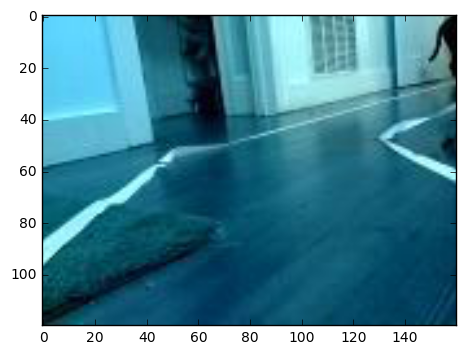

In [5]:
with open(file_path, 'rb') as f:
    X, Y = pickle.load(f)
    
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)

plt.imshow(X[0])

In [6]:
X_flipped = np.array([np.fliplr(i) for i in X])
Y_flipped = np.array([-i for i in Y])
train_X = np.concatenate([X, X_flipped])
train_Y = np.concatenate([Y, Y_flipped])
len(train_X)

15784

In [7]:
from keras.models import Model, load_model
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

In [18]:
img_in = Input(shape=(3, 120, 160), name='img_in')
angle_in = Input(shape=(1,), name='angle_in')

x = Convolution2D(8, 3, 3)(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(16, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Convolution2D(32, 3, 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

merged = Flatten()(x)

x = Dense(128)(merged)
x = Activation('linear')(x)
x = Dropout(.2)(x)

angle_out = Dense(1, name='angle_out')(x)

model = Model(input=[img_in], output=[angle_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img_in (InputLayer)              (None, 3, 120, 160)   0                                            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 8, 118, 158)   224         img_in[0][0]                     
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 8, 118, 158)   0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 8, 59, 79)     0           activation_6[0][0]               
___________________________________________________________________________________________

In [9]:
train_X = np.rollaxis(train_X, 3, 1)
train_X.shape

(15784, 3, 120, 160)

In [44]:
#shuffle  both X and Y the same way
def unison_shuffled_copies(*arrays):
    for i in range(len(arrays)-1):
        assert len(arrays[i]) == len(arrays[i+1])
    p = np.random.permutation(range(len(arrays[0])))
    return [arr[p] for arr in arrays]

def unison_shuffle_inplace(*arrays):
    for i in range(len(arrays)-1):
        assert len(arrays[i]) == len(arrays[i+1])
    p = np.random.permutation(range(len(arrays[0])))
    for arr in arrays:
        arr[:] = arr[p]


In [ ]:
train_X, train_Y = unison_shuffled_copies(train_X,train_Y)

In [15]:
import os
from keras import callbacks

model_path = os.path.expanduser('~/best_autopilot.hdf5')

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [38]:
model.fit(train_X, train_Y, batch_size=64, nb_epoch=10, validation_split=0.1, callbacks=callbacks_list)

Train on 14205 samples, validate on 1579 samples
Epoch 1/10
14205/14205 [==============================] - 10s - loss: 1967.8557 - val_loss: 470.3031
Epoch 2/10
14205/14205 [==============================] - 10s - loss: 422.9284 - val_loss: 395.0532
Epoch 3/10
14205/14205 [==============================] - 10s - loss: 363.2420 - val_loss: 353.2731
Epoch 4/10
14205/14205 [==============================] - 10s - loss: 317.2776 - val_loss: 327.3281
Epoch 5/10
14205/14205 [==============================] - 10s - loss: 283.6387 - val_loss: 314.7359
Epoch 6/10
14205/14205 [==============================] - 10s - loss: 261.2291 - val_loss: 296.5995
Epoch 7/10
14205/14205 [==============================] - 10s - loss: 245.2667 - val_loss: 307.3132
Epoch 8/10
14205/14205 [==============================] - 10s - loss: 229.3874 - val_loss: 302.0848
Epoch 9/10
14205/14205 [==============================] - 10s - loss: 217.6551 - val_loss: 273.4913
Epoch 10/10
14205/14205 [=========================

In [11]:
def read_speedfile(path=None):
    if path is None:
        path = aveta_data_path
    speedfile = os.path.join(path, "speeds.txt")
    ret = {}
    with open(speedfile) as fp:
        for line in fp:
            filename, l, r, l_, r_ = line.strip().split(",")
            ret[filename] = [os.path.join(path, filename), float(l), float(r), float(l_), float(r_)]
    return ret

In [12]:
speeds = read_speedfile()

We take a look at a few random images and the left and right speeds before and after the frame

(150, 400, 3)
(150, 400, 3)
(150, 400, 3)
(150, 400, 3)


/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


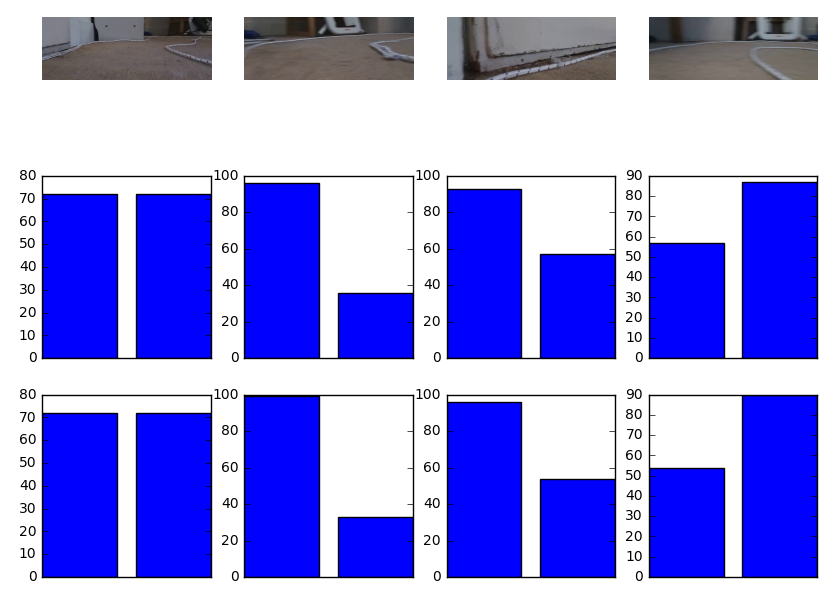

In [13]:
n_imgs = 4
imfiles = [np.random.choice(speeds.keys()) for _ in range(n_imgs)]
fig = plt.figure(figsize=(10, 8))
for i, imfile in enumerate(imfiles):
    impath, lt_speed, rt_speed, lt_speed_aft, rt_speed_aft = speeds[imfile]
    img = imresize(imread(impath, mode="RGB"), (150, 400))
    print(img.shape)
    ax = fig.add_subplot(3, n_imgs, i+1)
    ax.set_axis_off()
    ax.imshow(img)
    
    ax = fig.add_subplot(3, n_imgs, i+1+n_imgs)
    ax.bar([0, 1], [lt_speed, rt_speed])
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    
    ax = fig.add_subplot(3, n_imgs, i+1+2*n_imgs)
    ax.bar([0, 1], [lt_speed_aft, rt_speed_aft])
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.xaxis.set_ticks([])
    
fig.show()
    

In [14]:
imgs = []
b_speeds = []
y = []

for info in speeds.values():
    im = imread(info[0], mode="RGB")
    im = imresize(im, (120, 160))
    im = np.rollaxis(im, 2, 0) # so that shape is (3, 150, 400)
    imgs.append(im)
    b_speeds.append(info[1:3])
    y.append(info[3:5])
    

In [44]:
imgs, b_speeds, y = np.array(imgs), np.array(b_speeds), np.array(y)

In [45]:
print imgs.shape, b_speeds.shape, y.shape

(7850, 3, 120, 160) (7850, 2) (7850, 2)


In [16]:
model = load_model(model_path)
angle_out_layer = model.layers.pop()


In [48]:
for layer in model.layers:
    layer.trainable = False

In [22]:

model = load_model(os.path.expanduser("/home/ubuntu/best_autopilot.hdf5"))
model.save_weights(os.path.expanduser("~/best_autopilot_weights.hdf5"))


In [59]:
from keras.layers import Input, Convolution2D, Dropout, Merge, Activation, MaxPooling2D, Flatten, Dense, merge
from keras.models import Model, Sequential
#--- Load weights ---

angle_in = Input(shape=(1,), name='angle_in')

model = Sequential()
model.add(Convolution2D(8, 3, 3, input_shape=(3, 120, 160), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, 3, 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, 3, 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(128, activation="linear"))
model.add(Dropout(.2))
          
model.add(Dense(1, name='angle_out'))
          
model.load_weights(os.path.expanduser("/home/ubuntu/best_autopilot_weights.hdf5"))
# ----
model.layers.pop()

for layer in model.layers:
    layer.trainable = False
    


In [60]:
speed_branch = Sequential()
speed_branch.add(Dense(4, input_shape=(2,), name="speed_in", activation="relu"))

merged = Merge([model, speed_branch], mode="concat")

final_model = Sequential()
final_model.add(merged)
final_model.add(Dense(256, activation="linear"))
final_model.add(Dropout(0.2))
final_model.add(Dense(2, name="speed_out"))

final_model.compile(optimizer="adam", loss="mean_squared_error")
final_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_18 (Convolution2D) (None, 8, 118, 158)   224                                          
____________________________________________________________________________________________________
maxpooling2d_17 (MaxPooling2D)   (None, 8, 59, 79)     0                                            
____________________________________________________________________________________________________
convolution2d_19 (Convolution2D) (None, 16, 57, 77)    1168                                         
____________________________________________________________________________________________________
maxpooling2d_18 (MaxPooling2D)   (None, 16, 28, 38)    0                                            
___________________________________________________________________________________________

In [61]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = os.path.expanduser("~/aveta-model.hdf5")
save_best = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5, verbose=0, mode="auto")
cbs = [save_best, early_stop]

In [62]:
imgs, b_speeds, y = unison_shuffled_copies(np.array(imgs), np.array(b_speeds), np.array(y))

In [55]:
def unison_split(arrays, cutoff_fraction=0.9):
    """Split all input arrays (which must all have the same len()) such that cutoff_fraction
    is the fraction of elements in the first partition, and the rest go in the second partition.
    Returns a list of length 2*len(arrays), with the splits of arrays[i] in ret[2*i] and ret[2*i+1]."""
    for i in range(len(arrays)-1):
        assert len(arrays[i]) == len(arrays[i+1])
    
    cutoff_idx = int(cutoff_fraction * len(imgs))
    ret = []
    for arr in arrays:
        ret.append(arr[:cutoff_idx])
        ret.append(arr[cutoff_idx:])
    return ret

In [63]:
test_frac = 0.1
imgs_train, imgs_test, b_speeds_train, b_speeds_test, y_train, y_test = unison_split([
        np.array(imgs), np.array(b_speeds), np.array(y)
], cutoff_fraction=1-test_frac)

In [64]:
final_model.fit([imgs_train, b_speeds_train], y_train,
                nb_epoch=100, validation_split=0.1, callbacks=cbs, batch_size=320)

Train on 6358 samples, validate on 707 samples
Epoch 1/100
6358/6358 [==============================] - 2s - loss: 4454.1408 - val_loss: 4108.8627
Epoch 2/100
6358/6358 [==============================] - 1s - loss: 3767.5603 - val_loss: 3183.9377
Epoch 3/100
6358/6358 [==============================] - 1s - loss: 2638.9015 - val_loss: 1973.9165
Epoch 4/100
6358/6358 [==============================] - 1s - loss: 1531.2548 - val_loss: 1163.1827
Epoch 5/100
6358/6358 [==============================] - 1s - loss: 936.5458 - val_loss: 773.2861
Epoch 6/100
6358/6358 [==============================] - 1s - loss: 686.2900 - val_loss: 624.9274
Epoch 7/100
6358/6358 [==============================] - 1s - loss: 599.3053 - val_loss: 587.5207
Epoch 8/100
6358/6358 [==============================] - 1s - loss: 575.0209 - val_loss: 571.2573
Epoch 9/100
6358/6358 [==============================] - 1s - loss: 568.4876 - val_loss: 557.8890
Epoch 10/100
6358/6358 [==============================] - 1s - 

In [67]:
test_eval = final_model.evaluate([imgs_test, b_speeds_test], y_test, batch_size=320)
test_eval

785/785 [==============================] - 0s     


210.2655318922298

In [68]:
def plot_one_on_one(actual, predicted):
    fig = plt.figure()
    sides = ["left", "right"]
    for i in range(2):
        ax = fig.add_subplot(2, 1, i+1)
        ax.plot(actual[:,i], label="actual {}".format(sides[i]))
        ax.hold(True)
        ax.plot(predicted[:,i], label="predicted {}".format(sides[i]))
        ax.legend(bbox_to_anchor=(1.1, 1.2))
    fig.show()

In [69]:
test_pred = final_model.predict([imgs_test, b_speeds_test], batch_size=320)

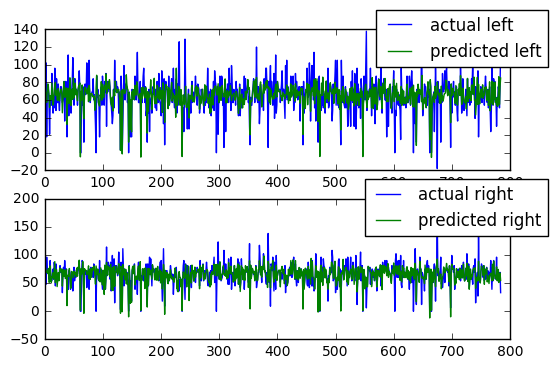

In [70]:
plot_one_on_one(y_test, test_pred)

In [ ]:
start, end = 1000, 1400
X = [imgs[start:end], b_speeds[start:end]]
actual_output = y[start:end]
plot_one_on_one(model.predict(X))
